In [1]:
import uproot
import awkward as ak
import numpy as np
from scipy.stats import poisson
import sklearn.metrics as m
import boost_histogram as bh
import glob
import os
from scipy.interpolate import interp1d

from coffea.nanoevents.methods import candidate
ak.behavior.update(candidate.behavior)

from matplotlib import pyplot as plt
import matplotlib as mpl
import matplotlib.gridspec as gridspec

from cycler import cycler
import mplhep as hep
# plt.style.use(hep.style.ROOT)
mpl.rcParams['mathtext.fontset'] = 'stix'
mpl.rcParams['font.family'] = 'STIXGeneral'

def _p4_from_ptetaphie(pt, eta, phi, energy):
    import vector
    vector.register_awkward()
    return vector.zip({'pt': pt, 'eta': eta, 'phi': phi, 'energy': energy})
def _p4_from_ptetaphim(pt, eta, phi, mass):
    import vector
    vector.register_awkward()
    return vector.zip({'pt': pt, 'eta': eta, 'phi': phi, 'mass': mass})

from concurrent.futures import ThreadPoolExecutor
from functools import reduce
from operator import add
import re

import random

(140, 160)
Num of nan_score: 0
Original points: 230461
Downsampled points: 3348
(160, 200)
Num of nan_score: 0
Original points: 334714
Downsampled points: 2979
(200, 350)
Num of nan_score: 0
Original points: 294933
Downsampled points: 1702
(350, 500)
Num of nan_score: 0
Original points: 24797
Downsampled points: 880
Processing fatjet ROC for pT range: (350, 500)
Signal events (nfj>=2): 50399
Background events (nfj>=2): 62879
Num of nan_score (fatjet): 0
Original points (fatjet): 25509
Downsampled points (fatjet): 553


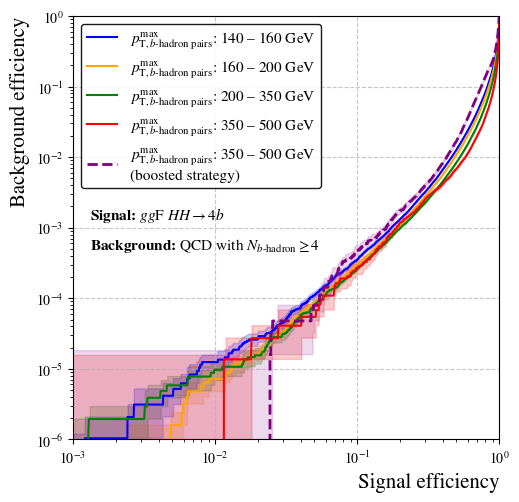

In [3]:
from multiprocessing import Pool, cpu_count
from functools import partial

def smart_downsample_roc(fpr, tpr, thresholds, background_lower, background_upper,
                         low_stat_threshold=1e-4,  
                         high_stat_points=2000):  
    
    bg_events = fpr 
    sig_events = tpr 
    
    mask_low_stat = bg_events < low_stat_threshold
    idx_low = np.where(mask_low_stat)[0]
    
    mask_high = ~mask_low_stat
    idx_high_candidates = np.where(mask_high)[0]
    
    if len(idx_high_candidates) > 0:
        min_bg = max(bg_events[idx_high_candidates[0]], 1e-9) 
        max_bg = bg_events[idx_high_candidates[-1]]
        
        min_sig = max(sig_events[idx_high_candidates[0]], 1e-9)
        max_sig = sig_events[idx_high_candidates[-1]]
        
        n_points_axis = high_stat_points // 2
        
        target_bg_values = np.logspace(np.log10(min_bg), np.log10(max_bg), n_points_axis)
        idx_bg_sampled = np.searchsorted(bg_events, target_bg_values)
        
        target_sig_values = np.logspace(np.log10(min_sig), np.log10(max_sig), n_points_axis)
        idx_sig_sampled = np.searchsorted(sig_events, target_sig_values)
        
        idx_sampled = np.union1d(idx_bg_sampled, idx_sig_sampled)
        idx_sampled = np.clip(idx_sampled, 0, len(fpr) - 1)
        
        idx_final = np.unique(np.concatenate((idx_low, idx_sampled)))
    else:
        idx_final = idx_low

    idx_final = np.sort(idx_final)
    
    return (fpr[idx_final], tpr[idx_final], thresholds[idx_final], 
            background_lower[idx_final], background_upper[idx_final])


def process_single_file(args):
    """Process a single file and return extracted data"""
    ifile, pred_folder, model_name, proc_name, is_signal, idxf = args
    
    try:
        if "forInfer2" in ifile:
            name = proc_name + "EXT_" + ifile.replace(".root", "").split("_")[-1]
        else:
            name = proc_name + "_" + ifile.replace(".root", "").split("_")[-1]
        
        print(f"Processing: {idxf} {name}")
        
        pred_file = f"{pred_folder}/{model_name}/pred_{name}.root"
        pred_data_tmp = uproot.lazy(pred_file)
        ntuple_data_tmp = uproot.lazy(ifile)
        
        trigger_selection = ((pred_data_tmp['pass_selection']==1) & 
                            (pred_data_tmp['pass_4j3b_selection']==1) & 
                            (ak.num(ntuple_data_tmp.gen_bhadron_pt,axis=1)==4))
        pred_data = pred_data_tmp[trigger_selection]
        ntuple_data = ntuple_data_tmp[trigger_selection]

        bhadrons = ak.zip({
            "pt": ntuple_data["gen_bhadron_pt"],
            "eta": ntuple_data["gen_bhadron_eta"],
            "phi": ntuple_data["gen_bhadron_phi"],
            "mass": ntuple_data["gen_bhadron_mass"], 
        }, with_name="PtEtaPhiMLorentzVector")

        b1, b2 = ak.unzip(ak.combinations(bhadrons, 2, axis=1))
        pT_max = ak.max((b1+b2).pt, axis=1)
    
        scores_ALLHH4b = np.zeros_like(pred_data['score_0'])
        for j in range(136):
            scores_ALLHH4b = scores_ALLHH4b + pred_data[f'score_{j}']
        score_hh4bvsqcd = scores_ALLHH4b / (scores_ALLHH4b + pred_data['score_136'])
        
        fj_XbbvsQCD = ntuple_data['fj_sophon_probXbb'] / (
            ntuple_data['fj_sophon_probXbb'] + ntuple_data['fj_sophon_probQCD']
        )
        
        sorted_indices = ak.argsort(fj_XbbvsQCD, axis=1, ascending=False)
        sorted_scores = fj_XbbvsQCD[sorted_indices]
        
        top2_scores = ak.pad_none(sorted_scores[:, :2], 2, axis=1, clip=True)
        fj_score_sum = ak.fill_none(top2_scores[:, 0], 0) + ak.fill_none(top2_scores[:, 1], 0)
        
        nfj_mask = ak.num(fj_XbbvsQCD, axis=1) >= 2
        
        return {
            'score': ak.to_numpy(score_hh4bvsqcd),
            'pT_max': ak.to_numpy(pT_max),
            'fj_score_sum': ak.to_numpy(fj_score_sum),
            'nfj_mask': ak.to_numpy(nfj_mask),
            'is_signal': is_signal,
            'weight': np.ones(len(pred_data))
        }
    except Exception as e:
        print(f"Error processing {ifile}: {e}")
        return None


process_list = ['ggHH','QCD']

pred_folder = "/home/olympus/tyyang99/weaver-core-dev/weaver/pheno/predict"
folder_pattern = "/data/bond/tyyang99/HH4b/sm_incl_derived_4j3bor2b/*"

model_name = "../../predict/hh4b_resolved_newsp4_allparts_nosel_138clswtop.noweights.ddp4-bs512-lr2e-3"

f, ax = plt.subplots(figsize=(5.5, 5.5))

pT_range_list = [(140, 160), (160, 200), (200, 350), (350, 500)]
# pT_range_list = [(140, 160), (160, 200), (200, 270), (270, 350), (350, 500)]
# pT_range_list = [(140, 160), (160, 180), (180, 220), (220, 300), (300, 500)]

color_list = ['blue', 'orange', 'green', 'red', 'purple',
              'cyan', 'magenta', 'yellow', 'black', 'navy']

file_data = []

matching_folders = glob.glob(folder_pattern)

file_args_list = []

for ifolder in matching_folders:
    proc_name = ifolder.split("/")[-1].split("_")[0]
    if proc_name not in process_list:
        continue

    if "forInfer2" in ifolder:
        continue
    
    is_signal = proc_name in ["ggHH", "qqHH"]
    
    matching_files = glob.glob(ifolder + "/*")

    if proc_name == "QCD" or proc_name == "TTbar":
        ext_folder = ifolder.replace("forInfer", "forInfer2")
        matching_files += glob.glob(ext_folder + "/*")
    
    for idxf, ifile in enumerate(matching_files):
        # if idxf > 0: continue
        file_args_list.append((ifile, pred_folder, model_name, proc_name, is_signal, idxf))

n_processes = min(40, len(file_args_list))
# n_processes = max(1, n_processes)

print(f"Processing {len(file_args_list)} files using {n_processes} processes...")

with Pool(processes=n_processes) as pool:
    results = pool.map(process_single_file, file_args_list)

file_data = [r for r in results if r is not None]

print(f"Successfully loaded {len(file_data)} files")

for i, pT_range in enumerate(pT_range_list):

    icolor = color_list[i]
    
    print('='*30)
    print(pT_range)
    print('='*30)
    
    pT_lower = pT_range[0]
    pT_upper = pT_range[1]
    
    signal_data = []
    background_data = []
    signal_data_fj = []
    background_data_fj = []
    
    for data in file_data:
        pT_cut = ((data['pT_max'] >= pT_lower) & (data['pT_max'] < pT_upper))
        
        weighted_data = {
            'score': data['score'][pT_cut],
            'weight': data['weight'][pT_cut]
        }
        
        pT_nfj_cut = pT_cut & data['nfj_mask']
        weighted_data_fj = {
            'score': data['fj_score_sum'][pT_nfj_cut],
            'weight': data['weight'][pT_nfj_cut]
        }
        
        if data['is_signal']:
            signal_data.append(weighted_data)
            signal_data_fj.append(weighted_data_fj)
        else:
            background_data.append(weighted_data)
            background_data_fj.append(weighted_data_fj)
    
    y_score_s = np.concatenate([d['score'] for d in signal_data]) if signal_data else np.array([])
    y_score_b = np.concatenate([d['score'] for d in background_data]) if background_data else np.array([])
    
    y_score = np.concatenate([y_score_s, y_score_b])
    y_true = np.concatenate([np.ones_like(y_score_s), np.zeros_like(y_score_b)])
    
    valid_mask = ~np.isnan(y_score)
    print("Num of nan_score:", np.sum(~valid_mask))
    y_true = y_true[valid_mask]
    y_score = y_score[valid_mask]
    
    fpr, tpr, thresholds = m.roc_curve(y_true, y_score)
    auc = m.auc(fpr, tpr)

    y_score_b_np = np.asarray(y_score_b)
    
    total_raw_b = len(y_score_b_np)
    if total_raw_b == 0:
        background_lower = np.zeros_like(thresholds)
        background_upper = np.zeros_like(thresholds)
    else:
        sorted_scores_asc = np.sort(y_score_b_np)
        pos = np.searchsorted(sorted_scores_asc, thresholds, side='right')
        raw_background_passed = total_raw_b - pos
    
        lower_raw, upper_raw = poisson.interval(0.68, raw_background_passed)
        upper_raw[raw_background_passed == 0] = -np.log(1 - 0.68)
        
        background_lower = lower_raw / total_raw_b
        background_upper = upper_raw / total_raw_b

    if len(fpr) > 5000:
        print(f"Original points: {len(fpr)}")
        fpr, tpr, thresholds, background_lower, background_upper = smart_downsample_roc(
            fpr, tpr, thresholds, background_lower, background_upper,
            low_stat_threshold=1e-4,  
            high_stat_points=600
        )
        print(f"Downsampled points: {len(fpr)}")

    signal_events = tpr 
    background_events = fpr 
    background_lower = np.maximum(background_lower, 1e-10)

    ax.fill_between(signal_events, background_lower, background_upper, color=icolor, alpha=0.2, step='post')
    ax.plot(signal_events, background_events, 
            color=icolor, 
            label="$p_{\\mathrm{T},b\\text{-}\\mathrm{hadron~pairs}}^{{\\mathrm{{max}}}}$: "+f"${pT_lower}" + "~–~" + f"{pT_upper}$ GeV")
    
    if pT_range == pT_range_list[-1]:
        print("Processing fatjet ROC for pT range:", pT_range)
        
        y_score_s_fj = np.concatenate([d['score'] for d in signal_data_fj]) if signal_data_fj else np.array([])
        y_score_b_fj = np.concatenate([d['score'] for d in background_data_fj]) if background_data_fj else np.array([])
        
        print(f"Signal events (nfj>=2): {len(y_score_s_fj)}")
        print(f"Background events (nfj>=2): {len(y_score_b_fj)}")
        
        if len(y_score_s_fj) > 0 and len(y_score_b_fj) > 0:
            y_score_fj = np.concatenate([y_score_s_fj, y_score_b_fj])
            y_true_fj = np.concatenate([np.ones_like(y_score_s_fj), np.zeros_like(y_score_b_fj)])
            
            # Remove NaN values from combined data for ROC
            valid_mask_fj = ~np.isnan(y_score_fj)
            print("Num of nan_score (fatjet):", np.sum(~valid_mask_fj))
            y_true_fj = y_true_fj[valid_mask_fj]
            y_score_fj = y_score_fj[valid_mask_fj]
            
            # Calculate ROC curve
            fpr_fj, tpr_fj, thresholds_fj = m.roc_curve(y_true_fj, y_score_fj)
            auc_fj = m.auc(fpr_fj, tpr_fj)
            
            y_score_b_fj_np = np.asarray(y_score_b_fj)
            valid_mask_b_fj = ~np.isnan(y_score_b_fj_np)
            y_score_b_fj_clean = y_score_b_fj_np[valid_mask_b_fj]  
            
            total_raw_b_fj = len(y_score_b_fj_clean)  
            if total_raw_b_fj == 0:
                background_lower_fj = np.zeros_like(thresholds_fj)
                background_upper_fj = np.zeros_like(thresholds_fj)
            else:
                sorted_scores_asc_fj = np.sort(y_score_b_fj_clean)  
                pos_fj = np.searchsorted(sorted_scores_asc_fj, thresholds_fj, side='right')
                raw_background_passed_fj = total_raw_b_fj - pos_fj
            
                lower_raw_fj, upper_raw_fj = poisson.interval(0.68, raw_background_passed_fj)
                upper_raw_fj[raw_background_passed_fj == 0] = -np.log(1 - 0.68)
                
                background_lower_fj = lower_raw_fj / total_raw_b_fj
                background_upper_fj = upper_raw_fj / total_raw_b_fj
            
            # Downsample if needed
            if len(fpr_fj) > 5000:
                print(f"Original points (fatjet): {len(fpr_fj)}")
                fpr_fj, tpr_fj, thresholds_fj, background_lower_fj, background_upper_fj = smart_downsample_roc(
                    fpr_fj, tpr_fj, thresholds_fj, background_lower_fj, background_upper_fj,
                    low_stat_threshold=1e-4,  
                    high_stat_points=600
                )
                print(f"Downsampled points (fatjet): {len(fpr_fj)}")
            
            signal_events_fj = tpr_fj
            background_events_fj = fpr_fj
            background_lower_fj = np.maximum(background_lower_fj, 1e-10)
            
            ax.fill_between(signal_events_fj, background_lower_fj, background_upper_fj, 
                           color=color_list[i+1], alpha=0.15, step='post')  
            ax.plot(signal_events_fj, background_events_fj, 
                   color=color_list[i+1], linestyle='--', linewidth=2,
                   label="$p_{\\mathrm{T},b\\text{-}\\mathrm{hadron~pairs}}^{{\\mathrm{{max}}}}$: "+f"${pT_lower}" + "~–~" + f"{pT_upper}$ GeV" + "\n(boosted strategy)")


ax.grid(True, linestyle='--', alpha=0.7)
ax.set_yscale('log')
ax.set_xscale('log')

ax.set_xlim(1e-3, 1)
ax.set_ylim(1e-6, 1)
ax.set_xlabel(r'Signal efficiency', ha='right', x=1.0, fontsize=15)
ax.set_ylabel('Background efficiency', ha='right', y=1.0, fontsize=15)

ax.text(0.04, 0.52, r'Signal: $gg\mathrm{F}~HH\rightarrow 4b$', fontsize=11, fontweight='bold', transform=ax.transAxes)
ax.text(0.04, 0.45, r'Background: $\mathrm{QCD~with}$ $N_{b\text{-}\mathrm{hadron}} \geq 4$', fontsize=11, fontweight='bold', transform=ax.transAxes)

ax.legend(loc='upper left', framealpha=0.9, edgecolor='black', fontsize=11)
plt.savefig('PLOTS/LorentzBoostRangeCompare.pdf', dpi=300, bbox_inches='tight')
plt.savefig('PLOTS/LorentzBoostRangeCompare.png', dpi=300, bbox_inches='tight')
plt.show()
